.png
(1, 3, 255, 255)
torch.Size([1, 16, 64, 64])
(208, 448)
(216, 328)
(272, 360)
(248, 296)
(248, 192)
(248, 184)
(248, 160)
(128, 232)
(160, 192)
(216, 184)
(280, 200)
(312, 248)


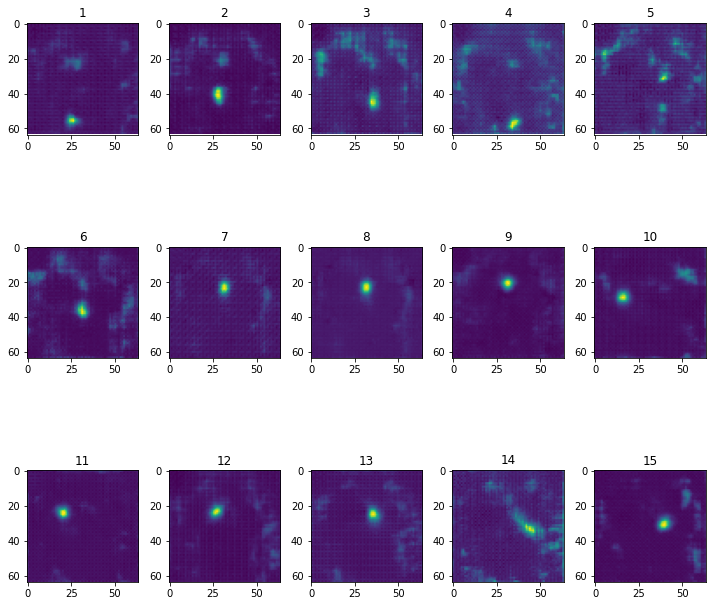

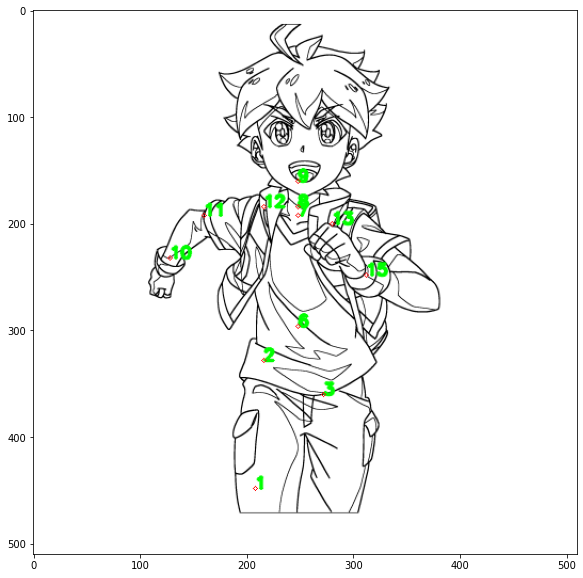

In [22]:
# ------------------------------------------------------------------------------
# Copyright (c) Microsoft Corporation. All rights reserved.
# Licensed under the MIT License.
# Written by Bin Xiao (Bin.Xiao@microsoft.com)
# ------------------------------------------------------------------------------


from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import argparse
import os
import pprint

import torch

import torch.backends.cudnn as cudnn

import sys
sys.path.append('../pose_estimation/')
import _init_paths
from utils.transforms import resize_keep_ratio
from core.config import config
from core.heatmap_keypoint import heatmap_to_keypoints
from utils.utils import create_logger

import dataset
import models
import cv2
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
args.workers

def visualize(img, joints, score=None):
    keypoint_num = 16
    pairs = [[0, 1], [1, 2], [2, 6], [3, 4], [3, 6], [4, 5], [6, 7],
             [7, 8], [8, 9], [8, 12], [8, 13], [10, 11], [11, 12],
             [13, 14], [14, 15]]
    color = np.random.randint(0, 256, (keypoint_num, 3)).tolist()
  

    for i in range(keypoint_num):
        print(joints[i,0:1])
        if joints[i, 0] > 0 and joints[i, 1] > 0:
            cv2.circle(img, tuple(joints[i, :2]), 2, tuple(color[i]), 2)
    if score:
        cv2.putText(img, score, (50, 50), cv2.FONT_HERSHEY_SIMPLEX, 1.2,
                    (128, 255, 0), 2)

    def draw_line(img, p1, p2):
        c = (0, 0, 255)
        if p1[0] > 0 and p1[1] > 0 and p2[0] > 0 and p2[1] > 0:
            #                cv2.line(img, tuple(p1), tuple(p2), c, 2)
            cv2.line(img, tuple(p1[0:2]), tuple(p2[0:2]), c, 2)

    for pair in pairs:
        draw_line(img, joints[pair[0] - 1], joints[pair[1] - 1])

    return img

def infer(data_numpy):
 
    
    cudnn.benchmark = config.CUDNN.BENCHMARK
    torch.backends.cudnn.deterministic = config.CUDNN.DETERMINISTIC
    torch.backends.cudnn.enabled = config.CUDNN.ENABLED
    model = eval('models.' + config.MODEL.NAME + '.get_pose_net')(
        config, is_train=False
    )
    config.TEST.MODEL_FILE = "../output/mpii/pose_resnet_50/256x256_d256x3_adam_lr1e-3/final_state.pth.tar"
    model.load_state_dict(torch.load(config.TEST.MODEL_FILE, map_location='cpu'))        
    # data_numpy= cv2.imread(img_path)
    data_numpy = data_numpy[..., ::-1]  # revert channel from bgr to rgb
    input, (new_w, new_h, pad_top, pad_right, pad_bot, pad_left) = resize_keep_ratio(data_numpy, [255,255])
    w_ratio = data_numpy.shape[1] / new_w
    h_ratio = data_numpy.shape[0] / new_h
    input = np.rollaxis(input, 2, 0)  # swap channel to first
    input = np.expand_dims(input,0)
    print(input.shape)
    output = model(torch.FloatTensor(input))
    print(output.shape)
    #visualize(data_numpy, output)
    return output

def main():
    file_path = '../data/hor01_020_k_A/color/A0001.tga'
    file_path = '../data/hor01_020_k_A/sketch_v3/A0005.png'
    ext = os.path.splitext(file_path)[-1]
    print(ext)
    if ext == '.tga':
        data_numpy = np.asarray(Image.open('../data/hor01_020_k_A/sketch_v3/A0007.png'))
    else:
        data_numpy= cv2.imread(file_path)[..., ::-1]

    img, (new_w, new_h, pad_top, pad_right, pad_bot, pad_left) = resize_keep_ratio(data_numpy, [255 * 2,255 * 2])

    sket = infer(data_numpy).cpu().detach().numpy()

    # visualize
    fig=plt.figure(figsize=(10, 25))
    rows = 8
    columns = 5

    font = cv2.FONT_HERSHEY_SIMPLEX
    for i in range(1, 16):
        ax = fig.add_subplot(rows,columns,i)
        ax.imshow(sket[0,i,...])
        pt = heatmap_to_keypoints(sket[0,i,...])
        if len(pt) > 0:
            center = (pt[0][0] * 4 * 2,pt[0][1] * 4 * 2) 
            print(center)
            cv2.putText(img, str(i), center, font, 0.5, (0,255,0), 2, cv2.LINE_AA)
            cv2.circle(img,center, 2, (255,0,0))
        ax.title.set_text(i)


    plt.tight_layout()
    plt.show()
    plt.figure(figsize=(10,10))
    plt.imshow(img)

main()

# joint id(0 - r ankle, 1 - r knee, 2 - r hip, 3 - l hip, 4 - l knee, 5 - l ankle, 6 - pelvis, 7 - thorax, 8 - upper neck, 9 - head top, 10 - r wrist, 11 - r elbow, 12 - r shoulder, 13 - l shoulder, 14 - l elbow, 15 - l wrist)
# mapping
mpii_map = ['ankle', 'l-knee', 'r-hip']
mapping = {
    'body_upper': 6,
    'neck': 8,
    'head': 9,
    'nose_top': None,
    'nose_root': None,
    'arm_left': 13,
    'elbow_left':   14,
    'wrist_left': 15,
    'thumb_left': None,
    'arm_right': 12,
    'elbow_right': 11,
    'wrist_right': 10,
    'thumb_right': None,
    'leg_left': 3,
    'knee_left': 4,
    'ankle_left': 5,
    'tiptoe_left': None,
    'leg_right': 2,
    'knee_right': 1,
    'ankle_right': 0,
    'tiptoe_right': None,
    'nose_tip': None,
    'width': None,
    'height': None}